In [28]:
import numpy as np
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.animation import FuncAnimation
import time
import pandas as pd
from numpy.linalg import norm
from itertools import count
from IPython import display
import seaborn as sns
from IPython.display import HTML
from scipy.io import loadmat
from operator_functions.pointer_func import pointer_vector
from operator_functions.AB_operator import A_operator,B_operator,uBC_Laplace,b_vector_creator
from operator_functions.Conjugate_gradient import CG_solver_transient,CG_solver,CG_solver_transient_Matrix
from operator_functions.bound_append import bound_appender
from operator_functions.helper_util import Func_GaussElimination
import time
from joblib import Parallel, delayed
from scipy.optimize import root
from numpy import cosh, zeros_like, mgrid, zeros
from scipy import optimize

In [2]:
def hessian(fun):
  return jit(jacfwd(jacrev(fun)))

In [29]:
##diffusivity
alpha  = 0.005 ;
## Delta t
dt = 0.02 ;
## grid
Nx=19
Ny=19
xtotal  = np.linspace(0,1,Nx+2)
x=xtotal[1:Nx+1]
ytotal  = np.linspace(0,1,Ny+2)
y=ytotal[1:Ny+1]
dx = x[1] - x[0] 
dy=y[1] - y[0] 
xv, yv = np.meshgrid(x, y, indexing='ij')
X,Y=np.meshgrid(xtotal, ytotal, indexing='ij')
kappa=0.02*np.exp(-((((xv-0.7)**2)/0.09)+(((yv-0.6)**2)/0.25)))
b=kappa/(alpha)
Q=np.zeros((Nx*Ny,1))
BCB=(-0.3)*np.ones(Nx)
BCL=0.5-0.5*np.cos(2*np.pi*y)
BCT=0.5+0.5*np.sin(4*np.pi*x-0.5*np.pi)
BCR=np.zeros(Ny)
cg_iter=10
b_residual_list=[]
cg_iter_list=[10,50,100,200,250]
#for cg_iter in cg_iter_list:
#    Steady_ss,Solution_Matrix,b_residual=CG_solver(Q,b,Nx,Ny,dx,dy,BCB,BCL,BCT,BCR,cg_iter)
#    b_residual_list.append(b_residual)
cg_iter=100
Steady_ss,Solution_Matrix,b_residual=CG_solver(Q,b,Nx,Ny,dx,dy,BCB,BCL,BCT,BCR,cg_iter)
N=Nx*Ny
matrix_A=[]
matrix_B=[]

BCB=(-0.3)*np.ones(Nx)
BCL=0.5-0.5*np.cos(2*np.pi*y)
BCT=0.5+0.5*np.sin(4*np.pi*x-0.5*np.pi)
BCR=np.zeros(Ny)
b_vector=b_vector_creator(kappa,Nx,Ny,dx,dy,BCB,BCL,BCT,BCR,dt,alpha)

In [21]:
def func_new(x_new,*args):
    Q=args
    s=B_operator(x_new,Nx,Ny,dx,dy,dt,alpha)-A_operator(Q,Nx,Ny,dx,dy,dt,alpha)-b_vector
    return norm(s)

In [30]:
sol_list=[]
x_new=Q
for i in range(10):
    res1 = optimize.fmin_cg(func_new, x_new, args=Q)
    sol_list.append(res1)
    print(i)

         Current function value: 0.000000
         Iterations: 16
         Function evaluations: 24628
         Gradient evaluations: 68
0
         Current function value: 0.000000
         Iterations: 16
         Function evaluations: 24628
         Gradient evaluations: 68
1
         Current function value: 0.000000
         Iterations: 16
         Function evaluations: 24628
         Gradient evaluations: 68
2
         Current function value: 0.000000
         Iterations: 16
         Function evaluations: 24628
         Gradient evaluations: 68
3
         Current function value: 0.000000
         Iterations: 16
         Function evaluations: 24628
         Gradient evaluations: 68
4
         Current function value: 0.000000
         Iterations: 16
         Function evaluations: 24628
         Gradient evaluations: 68
5
         Current function value: 0.000000
         Iterations: 16
         Function evaluations: 24628
         Gradient evaluations: 68
6
         Current function v

In [31]:
Mat_sol=np.zeros((Nx,Ny))
iQ=pointer_vector(Nx, Ny)
for i in range(0,Nx):
    for j in range(0,Ny):
        Mat_sol[i,j] = res1[iQ[i, j]]

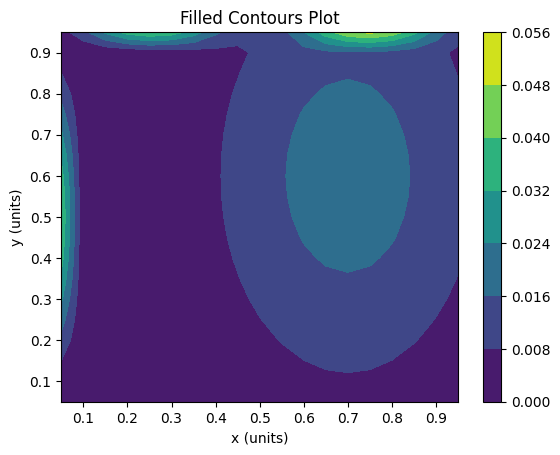

In [32]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(xv, yv, Mat_sol)
fig.colorbar(cp)
ax.set_title('Filled Contours Plot')
ax.set_xlabel('x (units)')
ax.set_ylabel('y (units)')
plt.show()

In [7]:
    kappa_base=0.02*np.exp(-((((xv-0.7)**2)/0.09)+(((yv-0.6)**2)/0.25)))
    kappa=dt*kappa_base
    Q=np.zeros((Nx*Ny,1))
    norm_list=[]
    b_vector=b_vector_creator(kappa,Nx,Ny,dx,dy,BCB,BCL,BCT,BCR,dt,alpha)
    b=A_operator(Q,Nx,Ny,dx,dy,dt,alpha)+b_vector
    for it in range(100):
        Q=root(func_new, np.zeros((Nx*Ny,1)), method='df-sane',args=(Q)).x
        norm_l2 = (norm(Q-Steady_ss))/(norm(Steady_ss))
        if it%10==0:
            print(it*dt,norm_l2)
        norm_list.append(norm_l2)
        if norm_l2<1e-4:
            break
        if it>3:
            if (norm_list[-1]-norm_list[-2])>0:
                break
    return Q,norm_list

In [8]:
Q,norm_list=timer_iteration(1)

0 0.9890542964092446
10 0.8869355150914063
20 0.7936964640195268
30 0.7078029016475909
40 0.6299433515600601
50 0.5618997170946339
60 0.5063739903525999
70 0.4667440243730494
80 0.44627637752577387


In [ ]:
norm_list_total=[]
iter_list_total=[]
t = time.time()
results = Parallel(n_jobs=2)(delayed(timer_iteration)(dt) for dt in [0.1,1,5,10])
print(time.time()-t)